# Lennard Jones simulation using ASE in CafChem

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MauricioCafiero/CafChemTeach/blob/main/notebooks/LennardJones_CafChem.ipynb)

## This notebook allows you to:
- Define a system of atoms and generate a random starting geometry.
- retreive Lennard Jones parameters.
- Optimize the initial geometry
- perform dynamics
- visalize each step.

## Requirements:

- Runs quickly on a CPU

## Install and import libraries

In [1]:
! pip install -q ase
!pip install -q py3Dmol
!pip install -q rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 56.7 MB/s eta 0:00:00


In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from ase import units
import ase.io
from ase import Atoms
from ase.optimize import BFGS
from ase.vibrations import Vibrations
from ase.thermochemistry import IdealGasThermo
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase.md.langevin import Langevin
from ase import units
from ase.constraints import FixAtoms
from ase.calculators.lj import LennardJones
from ase.io.trajectory import Trajectory
from ase.md.velocitydistribution import (
    MaxwellBoltzmannDistribution,
    Stationary,
    ZeroRotation,
)
from ase.md import MDLogger
from rdkit import Chem
from rdkit.Chem import AllChem
import py3Dmol
import shutil, os
import numpy as np

## Define functions

In [183]:
#@title Define functions
#@markdown - all functions used in the code below

def make_input(atoms_in: list, file_name = 'new_atoms.xyz'):
  '''
    Accepts a list of one or two types of atoms, finds the cutoff or average cutoff from
    the lj_dict, and sets a box-side length of 4*cutoff. then randomly places atoms in the box.
  '''
  if type(atoms_in) == str:
    atoms_in = [atoms_in]

  if len(atoms_in) == 0:
    print("No atoms provided")
    return None

  for atom in atoms_in:
    if atom not in lj_dict.keys():
      print(f"{atom} not in LJ parameters")
      return None

  unique_atoms = list(set(atoms_in))
  num_atom_types = len(unique_atoms)

  if num_atom_types > 2:
    print("Too many atoms provided")
    return None

  _, _, cutoff = get_LJ_params(unique_atoms)
  box_side = cutoff*np.sqrt(len(atoms_in))/2

  xyz_string = f'{len(atoms_in)}\n\n'
  for atom in atoms_in:
    position_x = np.random.uniform(0, box_side)
    position_y = np.random.uniform(0, box_side)
    position_z = np.random.uniform(0, box_side)
    xyz_string += f'{atom} {position_x} {position_y} {position_z}\n'

  if '.xyz' not in file_name:
    file_name += '.xyz'
  with open(file_name, 'w') as f:
    f.write(xyz_string)

  return f'{file_name} has been made!'

def smiles_to_atoms(smiles: str, charge = 0, spin = 1) -> ase.Atoms:
  '''
  receives a smiles string and returns an ASE atoms object. Adds Hs to
  molecule, optimizes with MMFF by RDKit. Makes and XYZ string,
  and an ASE atoms object.

    Args:
      smiles: SMILES string for molecule
      charge: charge of molecule
      spin: spin multiplicity of molecule

    Returns:
      atoms: ASE atoms object
  '''
  xyz_list = []
  atoms_list = ""
  mol = Chem.MolFromSmiles(smiles)
  molH = Chem.AddHs(mol)
  AllChem.EmbedMolecule(molH)
  AllChem.MMFFOptimizeMolecule(molH)
  xyz_string = f"{molH.GetNumAtoms()}\n\n"
  for atom in molH.GetAtoms():
    atoms_list += atom.GetSymbol()
    pos = molH.GetConformer().GetAtomPosition(atom.GetIdx())
    temp_tuple = (pos[0], pos[1], pos[2])
    xyz_list.append(temp_tuple)
    xyz_string += f"{atom.GetSymbol()} {pos[0]} {pos[1]} {pos[2]}\n"

  atoms = Atoms(atoms_list,xyz_list)
  atoms.info['charge'] = charge
  atoms.info['spin'] = spin

  return atoms

def XYZ_to_atoms(xyz_file: str, charges = None, spins = None) -> ase.Atoms:
  '''
  receives an XYZ file with one or more molecules and returns a list of ASE atoms objects.
  Updates charge and spin info for each molecule.

    Args:
      xyz_file: XYZ file with one or more molecules
      charges: list of charges for each molecule
      spins: list of spin multiplicities for each molecule

    Returns:
      all_mols: list of ASE atoms objects
  '''
  all_mols = []
  for mol in ase.io.iread(xyz_file, format="xyz"):
    all_mols.append(mol)

  if charges == None:
    charges = [0] * len(all_mols)
  if spins == None:
    spins = [1] * len(all_mols)

  for mol, charge, spin in zip(all_mols, charges, spins):
    mol.info['charge'] = charge
    mol.info['spin'] = spin

  return all_mols

def atoms_to_xyz(mol: ase.Atoms, filename: str):
  '''
    Receives an atoms object and a filename and writes an XYZ file.

        Args:
            mol: atoms object
            filename: filename for writing
        Returns:
            None; writes file
  '''
  ase.io.write(filename+".xyz", mol, format="xyz")

def opt_energy(mol: ase.Atoms, calculator, opt_flag = True,
               constraints_flag = False, constraints_list = []):
  '''
  Receives an ASE atoms object and calculates the energy using the UMA MLIP.
  if prompted, optimizes the structure and returns the optimized energy.

    Args:
      mol: ASE atoms object
      calculator: FAIRChemCalculator object
      opt_flag: boolean indicating whether to optimize the structure
    Returns:
      energy: energy of molecule in Hartree
  '''
  mol.calc = calculator
  initial_energy = mol.get_potential_energy()
  print(f"Initial energy: {0.0367493*initial_energy:.6f} ha")
  if opt_flag:

    if constraints_flag == True and len(constraints_list) != 0:
      c = FixAtoms(indices = constraints_list)
      mol.set_constraint(c)

    opt = BFGS(mol)
    opt.run(fmax=0.10)
    energy = mol.get_potential_energy()
    print(f"Final energy: {0.0367493*energy:.6f} ha")
    print(f"Energy difference: {0.0367493*(energy-initial_energy):.6f} ha")
    return 0.0367493*energy

  return 0.0367493*initial_energy

def run_md_from_xyz(infile: str, calculator,  temperature_K: float = 300.0, timestep_fs: float = 1.0, steps: int = 1000,
    output_traj: str = "md.traj", log_file: str = "md.log") -> Atoms:
    """
    Read the last frame from an XYZ file and run MD with ASE using VelocityVerlet.

    Returns None
    """
    # if log_file exists, remove it
    if os.path.exists(log_file):
        os.remove(log_file)
    if os.path.exists(output_traj):
        os.remove(output_traj)

    atoms = ase.io.read(infile, format = 'xyz')
    print(atoms.get_atomic_numbers())

    atoms.calc = calculator

      # Initialize velocities consistent with the target temperature
    MaxwellBoltzmannDistribution(atoms, temperature_K * units.kB)
    Stationary(atoms)
    ZeroRotation(atoms)

      # Use VelocityVerlet integrator
    dyn = VelocityVerlet(atoms, timestep_fs * units.fs)

      # Logging and trajectory writing
    logger = MDLogger(dyn, atoms, log_file, header=True, stress=False, peratom=True)
    dyn.attach(logger, interval=10)

    traj = Trajectory(output_traj, "w", atoms)
    dyn.attach(traj.write, interval=10)

      # Run dynamics
    dyn.run(steps)

    df = pd.read_table(log_file, sep="\s+")
    df["Ekin/N[eV]"] = pd.to_numeric(df["Ekin/N[eV]"], errors='coerce')
    y = df["Ekin/N[eV]"].to_list()
    #scale_start = sum(x)/len(x)
    #x = [val - scale_start for val in x]

    x = df["Time[ps]"].to_list()

    plt.plot(x,y)
    plt.xlabel("Time (fs)")
    plt.ylabel("Kinetic Energy (eV)")
    plt.show()

    md_xyz = output_traj.replace(".traj", ".xyz")
    #if md_xyz exists, remove it
    if os.path.exists(md_xyz):
        os.remove(md_xyz)
    #run the command line command ase convert:

    !ase convert md.traj md.xyz

def show_frame(xyz_file: str, frame_number = 0):
  '''
  receives an XYZ file and a frame number and shows the frame in 3D

    Args:
      xyz_file: XYZ file with one or more molecules
      frame_number: frame number to show in 3D
    Returns:
      None; shows frame in 3D
  '''
  with open(xyz_file, "r") as f:
    lines = f.readlines()

  num_atoms = int(lines[0].strip())  # Number of atoms from the first line
  frame_start = frame_number * (num_atoms + 2)  # Start of the desired frame
  frame_lines = lines[frame_start : frame_start + num_atoms + 2]  # Extract frame
  xyz_string = "".join(frame_lines)
  viewer = py3Dmol.view(width=800, height=400)
  viewer.addModel(xyz_string, "xyz")
  viewer.setStyle({"stick": {}, "sphere": {"radius": 0.5}})
  viewer.zoomTo()
  viewer.show()

def visualize_dynamics(xyz_string: str):
  '''
    input an XYZ string to vosualize the molecule in 3D
  '''
  viewer = py3Dmol.view(width=800, height=400)
  viewer.addModelsAsFrames(xyz_string, "xyz")
  viewer.setStyle({"stick": {}, "sphere": {"radius": 0.5}})
  viewer.animate({'loop': 'forward', 'reps': 2})
  viewer.zoomTo()
  viewer.show()

def get_LJ_params(atom_list: list):
  '''
  '''
  if type(atom_list) == str:
    atom_list = [atom_list]

  if len(atom_list) == 0:
    print("No atoms provided")
    return None

  if len(atom_list) == 1:
    if atom_list[0] not in lj_dict.keys():
      print(f"{atom_list[0]} not in LJ parameters")
      return None
    cutoff = lj_dict[atom_list[0]][0]
    epsilon = lj_dict[atom_list[0]][1]
    sigma = lj_dict[atom_list[0]][2]
    return sigma, epsilon, cutoff
  elif len(atom_list)  == 2:
    ave_cutoff = 0.0
    ave_epsilon = 1.0
    ave_sigma = 0.0
    for atom in atom_list:
      if atom not in lj_dict.keys():
        print(f"{atom} not in LJ parameters")
        return None
      ave_cutoff += lj_dict[atom][0]
      ave_epsilon *= lj_dict[atom][1]
      ave_sigma += lj_dict[atom][2]
    ave_cutoff /= 2
    ave_epsilon  = np.sqrt(ave_epsilon)
    ave_sigma /= 2
    return ave_sigma, ave_epsilon, ave_cutoff
  else:
    print("Too many atoms provided")
    return None


<>:186: SyntaxWarning: invalid escape sequence '\s'
<>:186: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-547623482.py:186: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_table(log_file, sep="\s+")


In [6]:
#@title Define Lennard Jones parameters
#@markdown - cutoff, epsilon, sigma

lj_dict = {'H': [2.20943, 4.47789, 0.552357],
 'He': [1.99561, 0.0009421, 0.498903],
 'Li': [9.1228, 1.04969, 2.2807],
 'Be': [6.8421, 0.572942, 1.71053],
 'B': [6.05811, 2.96703, 1.51453],
 'C': [5.41666, 6.36953, 1.35417],
 'N': [5.0603, 9.75379, 1.26508],
 'O': [4.70395, 5.12647, 1.17599],
 'F': [4.0625, 1.60592, 1.01562],
 'Ne': [4.13377, 0.0036471, 1.03344],
 'Na': [11.8311, 0.736745, 2.95778],
 'Mg': [10.0493, 0.0785788, 2.51233],
 'Al': [8.6239, 2.70067, 2.15597],
 'Si': [7.91118, 3.17431, 1.9778],
 'P': [7.62609, 5.0305, 1.90652],
 'S': [7.48355, 4.36927, 1.87089],
 'Cl': [7.26973, 4.48328, 1.81743],
 'Ar': [7.55482, 0.0123529, 1.88871],
 'K': [14.4682, 0.551799, 3.61705],
 'Ca': [12.5439, 0.132679, 3.13596],
 'Sc': [12.1162, 1.6508, 3.02906],
 'Ti': [11.4035, 1.18027, 2.85088],
 'V': [10.9046, 2.75249, 2.72615],
 'Cr': [9.90679, 1.53679, 2.4767],
 'Mn': [9.90679, 0.599888, 2.4767],
 'Fe': [9.40789, 1.18442, 2.35197],
 'Co': [8.98026, 1.27769, 2.24506],
 'Ni': [8.83772, 2.07572, 2.20943],
 'Cu': [9.40789, 2.04463, 2.35197],
 'Zn': [8.69517, 0.191546, 2.17379],
 'Ga': [8.69517, 1.0642, 2.17379],
 'Ge': [8.55263, 2.70171, 2.13816],
 'As': [8.48136, 3.9599, 2.12034],
 'Se': [8.55263, 3.38677, 2.13816],
 'Br': [8.55263, 1.97063, 2.13816],
 'Kr': [8.26754, 0.0173276, 2.06689],
 'Rb': [15.6798, 0.468265, 3.91995],
 'Sr': [13.898, 0.133923, 3.47451],
 'Y': [13.5417, 2.75975, 3.38542],
 'Zr': [12.4726, 3.05201, 3.11815],
 'Nb': [11.6886, 5.2782, 2.92215],
 'Mo': [10.9759, 4.47499, 2.74397],
 'Tc': [10.477, 3.38159, 2.61924],
 'Ru': [10.4057, 1.96172, 2.60142],
 'Rh': [10.1206, 2.40582, 2.53015],
 'Pd': [9.90679, 1.37097, 2.4767],
 'Ag': [10.3344, 1.64976, 2.58361],
 'Cd': [10.2632, 0.0377447, 2.56579],
 'In': [10.1206, 0.811314, 2.53015],
 'Sn': [9.90679, 1.90057, 2.4767],
 'Sb': [9.90679, 3.08828, 2.4767],
 'Te': [9.83552, 2.63123, 2.45888],
 'I': [9.90679, 1.53938, 2.4767],
 'Xe': [9.97807, 0.023888, 2.49452],
 'Cs': [17.3903, 0.416642, 4.34759],
 'Ba': [15.3235, 1.9, 3.83086],
 'La': [14.7533, 2.49961, 3.68832],
 'Ce': [14.5395, 2.57008, 3.63487],
 'Pr': [14.4682, 1.29946, 3.61705],
 'Nd': [14.3257, 0.819605, 3.58141],
 'Pm': [14.1831, 3.24134, 3.54578],
 'Sm': [14.1118, 0.521122, 3.52796],
 'Eu': [14.1118, 0.429918, 3.52796],
 'Gd': [13.9693, 2.09956, 3.49232],
 'Tb': [13.8267, 1.39999, 3.45669],
 'Dy': [13.6842, 0.690055, 3.42105],
 'Ho': [13.6842, 0.690055, 3.42105],
 'Er': [13.4704, 0.738766, 3.3676],
 'Tm': [13.5417, 0.521122, 3.38542],
 'Yb': [13.3278, 0.130399, 3.33196],
 'Lu': [13.3278, 1.43315, 3.33196],
 'Hf': [12.4726, 3.36086, 3.11815],
 'Ta': [12.1162, 4.00343, 3.02906],
 'W': [11.546, 6.86389, 2.88651],
 'Re': [10.7621, 4.43871, 2.69051],
 'Os': [10.2632, 4.26253, 2.56579],
 'Ir': [10.0493, 3.70287, 2.51233],
 'Pt': [9.69298, 3.1401, 2.42324],
 'Au': [9.69298, 2.3058, 2.42324],
 'Hg': [9.40789, 0.045414, 2.35197],
 'Tl': [10.3344, 0.577087, 2.58361],
 'Pb': [10.4057, 0.858988, 2.60142],
 'Bi': [10.5482, 2.07987, 2.63706],
 'Po': [9.97807, 1.89953, 2.49452],
 'At': [10.6908, 1.385442, 2.6727],
 'Rn': [10.6908, 0.0214992, 2.6727],
 'Fr': [18.5307, 0.3749778, 4.63267],
 'Ra': [15.7511, 1.71, 3.93777],
 'Ac': [15.3235, 2.249649, 3.83086],
 'Th': [14.682, 2.313072, 3.6705],
 'Pa': [14.2544, 1.169514, 3.56359],
 'U': [13.9693, 0.7376445, 3.49232],
 'Np': [13.5417, 2.917206, 3.38542],
 'Pu': [13.3278, 0.4690098, 3.33196],
 'Am': [12.8289, 0.3869262, 3.20724],
 'Cm': [12.045, 1.889604, 3.01124],
 'Bk': [11.9737, 1.259991, 2.99342],
 'Cf': [11.9737, 0.6210495, 2.99342],
 'Es': [11.7599, 0.6210495, 2.93997],
 'Fm': [11.9024, 0.6648894, 2.9756],
 'Md': [12.33, 0.4690098, 3.08251],
 'No': [12.5439, 0.1173591, 3.13596],
 'Lr': [11.4748, 1.289835, 2.86869],
 'Rf': [11.1897, 3.024774, 2.79742],
 'Db': [10.6195, 3.603087, 2.65488],
 'Sg': [10.1919, 6.177501, 2.54797],
 'Bh': [10.0493, 3.994839, 2.51233],
 'Hs': [9.55043, 3.836277, 2.38761],
 'Mt': [9.19407, 3.332583, 2.29852],
 'Ds': [9.1228, 2.82609, 2.2807],
 'Rg': [8.6239, 2.07522, 2.15597],
 'Cn': [8.69517, 0.0408726, 2.17379],
 'Nh': [9.69298, 0.5193783, 2.42324],
 'Fl': [10.1919, 0.7730892, 2.54797],
 'Mc': [11.546, 1.871883, 2.88651],
 'Lv': [12.4726, 1.709577, 3.11815],
 'Ts': [11.7599, 1.2468978, 2.93997],
 'Og': [11.1897, 0.0193493, 2.79742]}

## Lennard Jones simulations

### Define the initial system of up to 2 elements/ atom types

In [159]:
#@title Define system
#@markdown Up to two atom types (elements), but as many of them as you like.
#@markdown - if only one atom, leave second blank.
atom_1 = "O" # @param
num_atom_1 = 4 # @param
atom_2 = "N" # @param
num_atom_2 = 4 # @param

input_list = []
for i in range(num_atom_1):
  input_list.append(atom_1)
if atom_2 != '' and num_atom_2 != None:
  for i in range(num_atom_2):
    input_list.append(atom_2)

In [172]:
make_input(input_list, 'oxygen_nitrogen.xyz')

'oxygen_nitrogen.xyz has been made!'

In [173]:
show_frame('oxygen_nitrogen.xyz')

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Define the atoms object and get the lennard Jones parameters; set-up the calculator

In [174]:
mix_atoms = XYZ_to_atoms("oxygen_nitrogen.xyz")[0]

In [175]:
atoms_list = list(set(mix_atoms.get_chemical_symbols()))
print(atoms_list)
try:
  sigma, epsilon, cutoff = get_LJ_params(atoms_list)
  print(f"sigma: {sigma}, epsilon: {epsilon}, cutoff: {cutoff}")
except:
  print("Error getting LJ parameters")

['O', 'N']
sigma: 1.220535, epsilon: 7.0712454222223124, cutoff: 4.882125


In [176]:
calculator = LennardJones(sigma = sigma, epsilon = epsilon, cutoff = cutoff)

### Perform the optimization

In [177]:
energy = opt_energy(mix_atoms, calculator, opt_flag = True)

Initial energy: -0.119563 ha
      Step     Time          Energy          fmax
BFGS:    0 14:52:58       -3.253472        3.269244
BFGS:    1 14:52:58       -3.905417        4.276564
BFGS:    2 14:52:58       -9.404374       12.410239
BFGS:    3 14:52:58       -9.257033      104.929519
BFGS:    4 14:52:58      -12.312730       11.821758
BFGS:    5 14:52:58       -8.832549       88.997331
BFGS:    6 14:52:58      -13.948718       13.388276
BFGS:    7 14:52:58      -16.803246       13.984809
BFGS:    8 14:52:58      -21.145971       13.889035
BFGS:    9 14:52:58      -20.430565       17.181948
BFGS:   10 14:52:58      -21.356914        6.380869
BFGS:   11 14:52:58      -20.758084       27.283286
BFGS:   12 14:52:58      -21.522032        2.757535
BFGS:   13 14:52:58      -21.560269        1.986655
BFGS:   14 14:52:58      -21.586531        1.094411
BFGS:   15 14:52:58      -21.604848        1.715012
BFGS:   16 14:52:58      -21.664558       12.937134
BFGS:   17 14:52:58      -21.761145  

### Collect optimized coordinates and perform dynamics

In [179]:
atoms_to_xyz(mix_atoms, "mix_opt")

[8 8 8 8 7 7 7 7]


/usr/local/lib/python3.12/dist-packages/ase/md/md.py:54: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


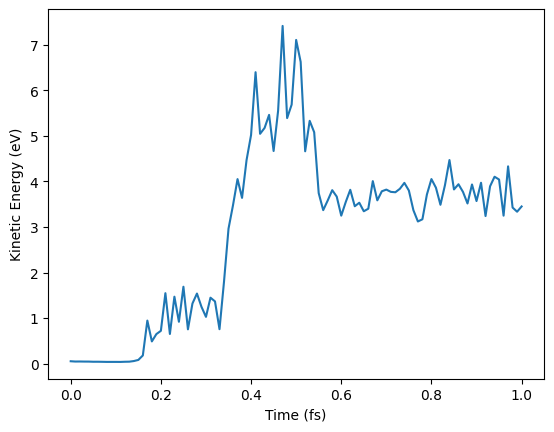

In [180]:
run_md_from_xyz("mix_opt.xyz", calculator)

#### Show a single frame

In [181]:
show_frame("md.xyz", 5)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

#### Show whole simulation

In [185]:
f = open("md.xyz", "r")
lines = f.readlines()
f.close()

xyz_string = ''.join(lines)
visualize_dynamics(xyz_string)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.